In [9]:
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import cv2
import numpy as np
import pandas as pd
from PIL import Image

def apply_adaptive_threshold(img):
    # 이미지를 그레이스케일로 변환
    gray_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    # 적응형 스레시홀딩 적용
    th_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    # PIL 이미지로 변환하여 반환
    return Image.fromarray(th_img)

# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # 이미지 크기를 (50, 50)으로 변경
    transforms.Lambda(apply_adaptive_threshold),  # 적응형 스레시홀딩 적용 후 텐서로 변환
    transforms.ToTensor()  # 이미지를 텐서로 변환
])
data = ImageFolder(root="./add_data", transform=transform)
data2 = ImageFolder(root="./data_test", transform=transform)

In [10]:
data_loader = DataLoader(data, batch_size=10, shuffle=True)
test_loader = DataLoader(data2, batch_size=8, shuffle=True)

In [11]:
images, labels = next(iter(data_loader))
print(images.shape, labels.shape) # shape : [개수, 채널 수, 높이, 너비]

torch.Size([10, 1, 50, 50]) torch.Size([10])


In [12]:
class Mob_Dog(nn.Module):
    def __init__(self):
        super(Mob_Dog, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.dropout = nn.Dropout(p=0.5)  # Dropout 추가
        self.batchnorm1 = nn.BatchNorm2d(6)  # Batch Normalization 추가
        self.batchnorm2 = nn.BatchNorm2d(16)  # Batch Normalization 추가
        self.batchnorm3 = nn.BatchNorm1d(120)  # Batch Normalization 추가
        self.batchnorm4 = nn.BatchNorm1d(84)  # Batch Normalization 추가
        
    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))  # Batch Normalization 추가
        
        x = x.view(-1, 16 * 9 * 9)
        x = F.relu(self.batchnorm3(self.fc1(x)))  # Batch Normalization 추가
        x = F.relu(self.batchnorm4(self.fc2(x)))  # Batch Normalization 추가
        x = self.dropout(x)  # Dropout 추가
        x = self.fc3(x)
        return x


In [13]:
# 모델 객체 생성, 옵티마이저 생성
model = Mob_Dog()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [14]:
def get_accuracy(loader, model):
    total=0
    correct=0
    for data in loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # dim=1을 주어 최종 값 계산
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return correct / total

In [15]:
from tqdm import tqdm # 프로그레스 바 생성
from torch.optim.lr_scheduler import ReduceLROnPlateau # 스케줄러 생성 
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=15, verbose=True)

loss_list=[]
tas_list=[]
tes_list=[]
max=0
for epoch in range(100): # 10회 반복 
    running_loss = 0.0 # 1 epoch당 누적 로스값 
    #==================================================================================
    pbar = tqdm(enumerate(data_loader), total=len(data_loader)) 
    for i, data in pbar: # pbar가 데이터 로더 역할 수행
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # 로스 누적 
        if i % 10 == 9:
            pbar.set_description(f'Epoch [{epoch + 1}/{10}], 횟수 [{i + 1}/{len(data_loader)}], Loss: {running_loss / 10:.4f}')
            loss_list.append(running_loss)
            running_loss = 0.0
    #==================================================================================   
    # 모델 평가

    with torch.no_grad():
        train_accuracy = get_accuracy(data_loader, model)
        test_accuracy = get_accuracy(test_loader, model)
    print(f'{epoch} Epoch 종료 후 train_score : {(100 * train_accuracy)}')
    print(f'{epoch} Epoch 종료 후 test_score : {(100 * test_accuracy)}')
    tas_list.append(train_accuracy)
    tes_list.append(test_accuracy)
    if max < test_accuracy:
        max = test_accuracy
        torch.save(model, 'model.pth')
    
    scheduler.step(loss)
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f"Early Stopping at : {epoch} Epoch")
        break

Epoch [1/10], 횟수 [40/43], Loss: 0.4644: 100%|██████████| 43/43 [00:01<00:00, 38.39it/s]


0 Epoch 종료 후 train_score : 84.59715639810426
0 Epoch 종료 후 test_score : 63.04347826086957


Epoch [2/10], 횟수 [40/43], Loss: 0.3437: 100%|██████████| 43/43 [00:00<00:00, 43.95it/s]


1 Epoch 종료 후 train_score : 91.9431279620853
1 Epoch 종료 후 test_score : 61.95652173913043


Epoch [3/10], 횟수 [40/43], Loss: 0.2762: 100%|██████████| 43/43 [00:00<00:00, 44.13it/s]


2 Epoch 종료 후 train_score : 95.02369668246445
2 Epoch 종료 후 test_score : 63.04347826086957


Epoch [4/10], 횟수 [40/43], Loss: 0.1758: 100%|██████████| 43/43 [00:01<00:00, 41.81it/s]


3 Epoch 종료 후 train_score : 97.1563981042654
3 Epoch 종료 후 test_score : 59.78260869565217


Epoch [5/10], 횟수 [40/43], Loss: 0.0862: 100%|██████████| 43/43 [00:00<00:00, 44.19it/s]


4 Epoch 종료 후 train_score : 98.81516587677726
4 Epoch 종료 후 test_score : 57.608695652173914


Epoch [6/10], 횟수 [40/43], Loss: 0.0666: 100%|██████████| 43/43 [00:00<00:00, 46.47it/s]


5 Epoch 종료 후 train_score : 97.86729857819904
5 Epoch 종료 후 test_score : 63.04347826086957


Epoch [7/10], 횟수 [40/43], Loss: 0.0518: 100%|██████████| 43/43 [00:00<00:00, 46.16it/s]


6 Epoch 종료 후 train_score : 97.39336492890996
6 Epoch 종료 후 test_score : 66.30434782608695


Epoch [8/10], 횟수 [40/43], Loss: 0.0394: 100%|██████████| 43/43 [00:00<00:00, 45.19it/s]


7 Epoch 종료 후 train_score : 96.91943127962085
7 Epoch 종료 후 test_score : 64.13043478260869


Epoch [9/10], 횟수 [40/43], Loss: 0.0259: 100%|██████████| 43/43 [00:01<00:00, 42.02it/s]


8 Epoch 종료 후 train_score : 98.10426540284361
8 Epoch 종료 후 test_score : 61.95652173913043


Epoch [10/10], 횟수 [40/43], Loss: 0.0272: 100%|██████████| 43/43 [00:00<00:00, 44.19it/s]


9 Epoch 종료 후 train_score : 98.81516587677726
9 Epoch 종료 후 test_score : 64.13043478260869


Epoch [11/10], 횟수 [40/43], Loss: 0.0380: 100%|██████████| 43/43 [00:00<00:00, 43.99it/s]


10 Epoch 종료 후 train_score : 98.34123222748815
10 Epoch 종료 후 test_score : 67.3913043478261


Epoch [12/10], 횟수 [40/43], Loss: 0.1191: 100%|██████████| 43/43 [00:00<00:00, 45.72it/s]


11 Epoch 종료 후 train_score : 96.91943127962085
11 Epoch 종료 후 test_score : 68.47826086956522


Epoch [13/10], 횟수 [40/43], Loss: 0.1524: 100%|██████████| 43/43 [00:00<00:00, 45.15it/s]


12 Epoch 종료 후 train_score : 96.44549763033176
12 Epoch 종료 후 test_score : 68.47826086956522


Epoch [14/10], 횟수 [40/43], Loss: 0.0647: 100%|██████████| 43/43 [00:00<00:00, 46.55it/s]


13 Epoch 종료 후 train_score : 96.6824644549763
13 Epoch 종료 후 test_score : 73.91304347826086


Epoch [15/10], 횟수 [40/43], Loss: 0.0357: 100%|██████████| 43/43 [00:00<00:00, 46.40it/s]


14 Epoch 종료 후 train_score : 97.39336492890996
14 Epoch 종료 후 test_score : 66.30434782608695


Epoch [16/10], 횟수 [40/43], Loss: 0.3643: 100%|██████████| 43/43 [00:00<00:00, 46.36it/s]


15 Epoch 종료 후 train_score : 96.44549763033176
15 Epoch 종료 후 test_score : 71.73913043478261


Epoch [17/10], 횟수 [40/43], Loss: 0.1597: 100%|██████████| 43/43 [00:00<00:00, 45.57it/s]


16 Epoch 종료 후 train_score : 95.02369668246445
16 Epoch 종료 후 test_score : 67.3913043478261


Epoch [18/10], 횟수 [40/43], Loss: 0.1539: 100%|██████████| 43/43 [00:00<00:00, 45.31it/s]


17 Epoch 종료 후 train_score : 98.5781990521327
17 Epoch 종료 후 test_score : 72.82608695652173


Epoch [19/10], 횟수 [40/43], Loss: 0.0754: 100%|██████████| 43/43 [00:00<00:00, 45.34it/s]


18 Epoch 종료 후 train_score : 95.73459715639811
18 Epoch 종료 후 test_score : 73.91304347826086


Epoch [20/10], 횟수 [40/43], Loss: 0.1112: 100%|██████████| 43/43 [00:00<00:00, 44.85it/s]


19 Epoch 종료 후 train_score : 98.34123222748815
19 Epoch 종료 후 test_score : 72.82608695652173


Epoch [21/10], 횟수 [40/43], Loss: 0.0456: 100%|██████████| 43/43 [00:00<00:00, 43.79it/s]


20 Epoch 종료 후 train_score : 99.0521327014218
20 Epoch 종료 후 test_score : 72.82608695652173


Epoch [22/10], 횟수 [40/43], Loss: 0.0142: 100%|██████████| 43/43 [00:00<00:00, 45.18it/s]


21 Epoch 종료 후 train_score : 98.81516587677726
21 Epoch 종료 후 test_score : 68.47826086956522


Epoch [23/10], 횟수 [40/43], Loss: 0.0829: 100%|██████████| 43/43 [00:00<00:00, 43.58it/s]


22 Epoch 종료 후 train_score : 98.10426540284361
22 Epoch 종료 후 test_score : 73.91304347826086


Epoch [24/10], 횟수 [40/43], Loss: 0.0136: 100%|██████████| 43/43 [00:00<00:00, 43.38it/s]


23 Epoch 종료 후 train_score : 99.52606635071089
23 Epoch 종료 후 test_score : 75.0


Epoch [25/10], 횟수 [40/43], Loss: 0.0217: 100%|██████████| 43/43 [00:01<00:00, 42.24it/s]


24 Epoch 종료 후 train_score : 100.0
24 Epoch 종료 후 test_score : 77.17391304347827


Epoch [26/10], 횟수 [40/43], Loss: 0.0735: 100%|██████████| 43/43 [00:01<00:00, 41.37it/s]


25 Epoch 종료 후 train_score : 99.76303317535546
25 Epoch 종료 후 test_score : 76.08695652173914


Epoch [27/10], 횟수 [40/43], Loss: 0.0529: 100%|██████████| 43/43 [00:01<00:00, 38.50it/s]


26 Epoch 종료 후 train_score : 99.0521327014218
26 Epoch 종료 후 test_score : 77.17391304347827


Epoch [28/10], 횟수 [40/43], Loss: 0.0180: 100%|██████████| 43/43 [00:01<00:00, 38.73it/s]


27 Epoch 종료 후 train_score : 98.34123222748815
27 Epoch 종료 후 test_score : 65.21739130434783
Early Stopping at : 27 Epoch


<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

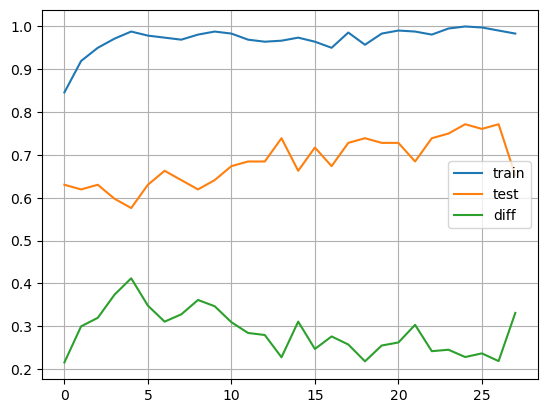

In [16]:
import matplotlib.pyplot as plt

#plt.plot(loss_list)
plt.plot(tas_list, label="train")
plt.plot(tes_list, label="test")
plt.plot(np.array(tas_list)-np.array(tes_list), label="diff")
plt.grid(True)
plt.legend()
plt.ylabel

In [17]:
# 확실히 높아진 성능을 자랑한다....

In [18]:
model = Mob_Dog()
model.load_state_dict(torch.load('model.pth'))
model.eval()

# 이미지 예측
img = cv2.imread('./data/mop_dog/74.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (50, 50))
img = img / 255.0
img = torch.Tensor(img)
img = img.unsqueeze(0).unsqueeze(1)

with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output.data, 1)
predicted, output # 예측도 슬슬,,,잘 나온다!

TypeError: Expected state_dict to be dict-like, got <class '__main__.Mob_Dog'>.

In [ ]:
# 추가적으로 데이터셋을 늘려보고, 정규화와 이퀄라이즈, Clahe를 사용해보자! 